# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

# Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


we can make few observations based on the data description in the competition

* Few **groups** are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The **ind** indicates most probably **individual**,**reg** is probably **registration**,**car** is self-explanatory, **calc** suggests as **calculated** field.
* The postfix **bin** is used for **binary** features
* The postfix **cat** is used for **categorical** features
* Features without the **bin** or **cat** indications are real numbers (continuous values) of integers (ordinal values)
* A **missing value** is indicated by **-1**
* The value that is subject of prediction is in the **target** column. This one indicates whether or not a claim was filed for that insured person
* **id** is a data input ordinal number.

indeed, we can observe the **cat** values are **categorical**, integer values ranging from **\\0** to **\\n**, **bin** values are **binary** (either 0 or 1)

Let's see how many rows and columns are in the data

In [4]:
print("Train data (rows, cols):", train.shape, "\nTest data (rows, cols):", test.shape)

Train data (rows, cols): (595212, 59) 
Test data (rows, cols): (892816, 58)


There re 59 columns in the train data and only 58 columns in the test data. Let's check the difference between the columns set in the two data.

In [5]:
print("Columns in the train and not in the test data:", set(train.columns)- set(test.columns))

Columns in the train and not in the test data: {'target'}


 Since from this dataset should have been extracted th **target**, this seems fine.

# Meta data

To make easier the manipulation of data, we will associate few meta information to the variables in the train dataset. This will facilitate the selection of various types of features for analysis, inpection or modeling. we are using as well a **category** field for the **car**,**ind**,**reg**, and **calc** types of features.

What meta data will be used:
* **role**: input, ID, target
* **level**: categorical, interval, ordinal, binary
* **keep**: True or False
* **dtype**: int, float, char
* **category**: ind, reg, car, calc

In [6]:
data = []

for feature in train.columns:
    if feature == "target":
        role = 'target'
    elif feature == "id":
        role = "id"
    else:
        role = "input"
    
    if 'bin' in feature or feature == 'target':
        level = 'binary'
    elif 'cat' in feature or feature =='id':
        level = 'categorical'
    elif train[feature].dtype == float:
        level = 'interval'
    else:
        level = 'ordinal'
    
    keep = True
    if feature == 'id':
        keep = False
    
    dtype = train[feature].dtype
    
    category = 'none'
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = "registration"
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = "calculated"
    
    feature_dict = {
        'varname': feature,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype,
        'category': category
    }
    data.append(feature_dict)
    
meta = pd.DataFrame(data, columns=['varname','role','level','keep','dtype','category'])
meta.set_index('varname', inplace = True)
meta

,role,level,keep,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,ordinal,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,ordinal,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [7]:
meta[(meta.level=='categorical')&(meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

Let's inspect all features to see how many category distinct values do we have

In [8]:
pd.DataFrame({'count':meta.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


We have 20 calculated, 16 car, 18 individual, and 3 registration

Let's inspect now all features, to see how many use and type distinct values do we have

In [9]:
pd.DataFrame({'count':meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,interval,10
4,input,ordinal,16
5,target,binary,1


# Data Analysis and statistics 

## Target Variable

<Figure size 432x288 with 0 Axes>

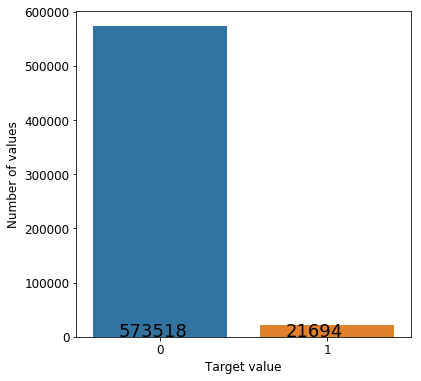

In [10]:
plt.figure()
fig,ax = plt.subplots(figsize=(6,6))
x=train['target'].value_counts().index.values
y=train['target'].value_counts().values

# Bar plot
# Order the bars descending on target mean

sns.barplot(ax=ax, x=x,y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
for i, v in enumerate(y):
    ax.text(i-.25,
             v/y[i]+100,
             y[i],
           fontsize=18)
plt.show()

Only 3.78% of the target data have 1 value. This means that the train data is highly imbalanced. We can either undersample the records with target = 0 or over sample records with target = 1; because it is a large dataset, we will do undersampling of records with target = 0

## Interval features

In [11]:
var = meta[(meta.level=='interval') & (meta.keep)].index
train[var].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [12]:
(pow(train['ps_car_12']*10,2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [13]:
(pow(train['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### Feature with missing values

**ps_reg_03**,**ps_car_12**,**ps_car_14** have missing values (their minimum value is -1)

### Registration features

**ps_reg_01** and **ps_reg_02** are fractions with denominatior 10 (values of 0.1, 0.2, 0.3)

### Car Features

**ps_car_12** are (with some approximations) square roots (divided by 10) of natural numbers whilst **ps_car_15** are square roots of natural numbers. Let's represent the values using pairplot

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


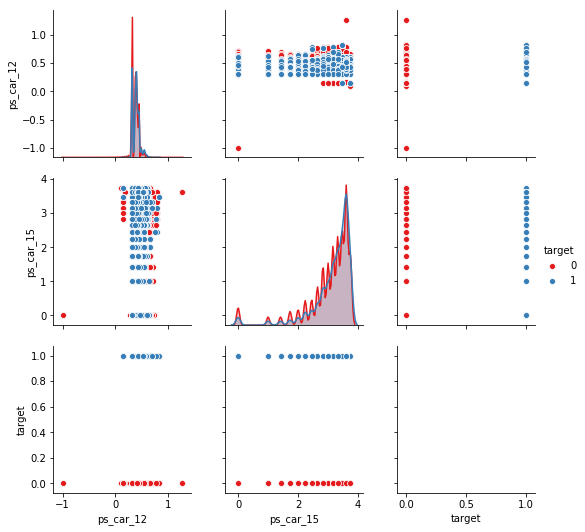

In [14]:
sample = train.sample(frac=0.5)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette = 'Set1', diag_kind='kde')
plt.show()


### Calculated features

The features **ps_calc_01**, **ps_calc_02**, **ps_calc_03** have very similar distributions and could be some kind of ratio, since the maximum value is for all three 0.9. The other calculated values have maximum value an integer value (5,6,7,10,12)

Let's visualize the real features distribution using density plot

<Figure size 432x288 with 0 Axes>

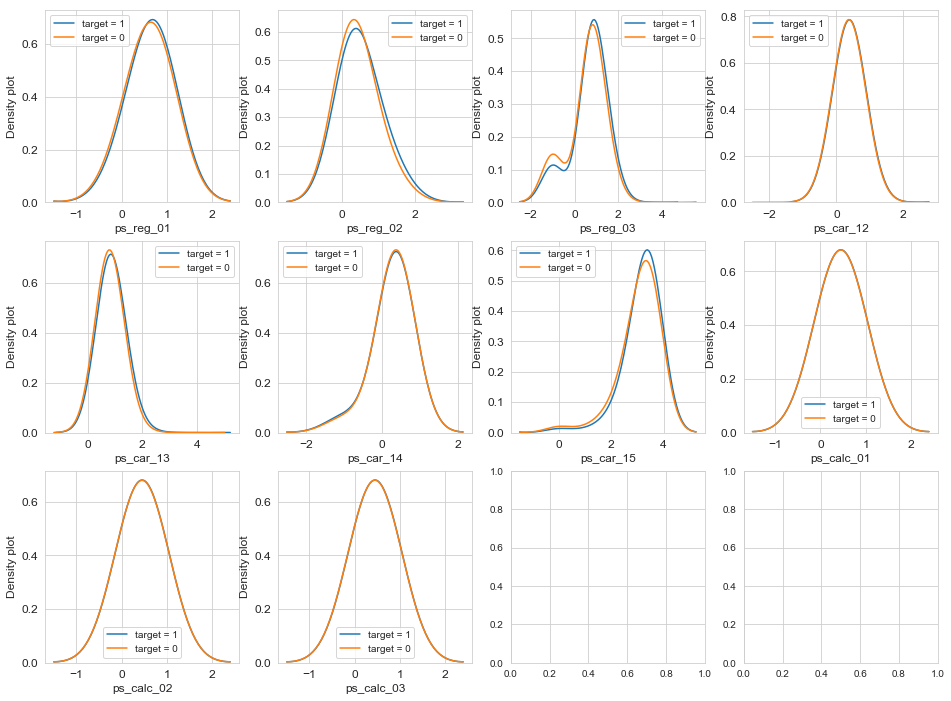

In [15]:
var = meta[(meta.level == 'interval') & (meta.keep)].index
i=0
t1 = train.loc[train['target'] != 0]
t0 = train.loc[train['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))
for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

**ps_reg_02**,**ps_car_12**,**ps_car_15** shows the most different distributions between sets of values associated with **target = 0** and **target = 1**

Let's visualize the correlation between the interval features

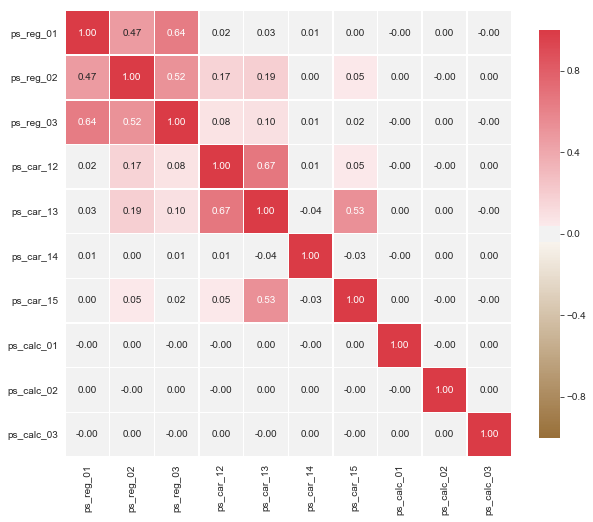

In [16]:
def correlation_heatmap(var):
    correlations = train[var].corr()
    
    cmap = sns.diverging_palette(50,10,as_cmap=True)
    
    fig,ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmin=-1, vmax=1.0, center=0, fmt='.2f',
               square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.75})
    plt.show()
    
var = meta[(meta.level == 'interval') & (meta.keep)].index
correlation_heatmap(var)

Let's visualize the plots of the variables with strong correlations. These are

* **ps_reg_01** with **ps_reg_02** (0.47)
* **ps_reg_01** with **ps_reg_03** (0.64)
* **ps_reg_02** with **ps_reg_03** (0.52)
* **ps_car_12** with **ps_car_13** (0.67)
* **ps_car_13** with **ps_car_15** (0.53)

To show the pairs of values that are corerelated we use *pairplot*. Before representing the pairs, we subsample the data, using only 2% in the sample

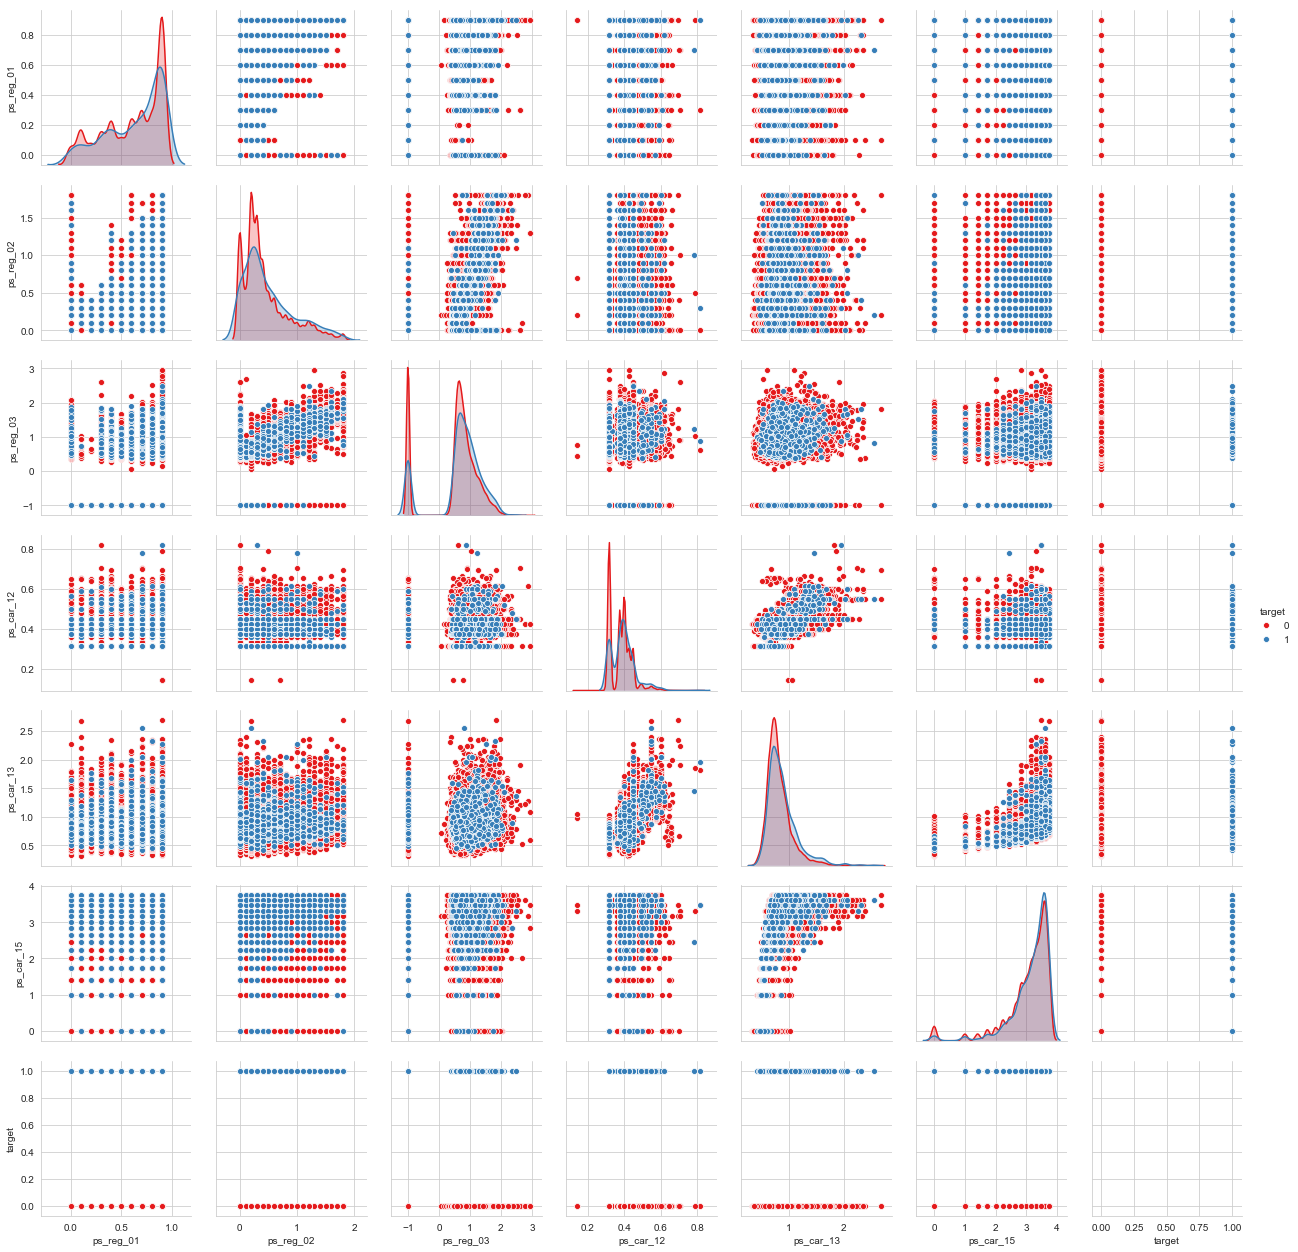

In [17]:
sample = train.sample(frac=0.05)
var = ['ps_reg_01','ps_reg_02','ps_reg_03','ps_car_12','ps_car_13','ps_car_15','target']
sample = sample[var]
sns.pairplot(sample, hue="target", palette="Set1", diag_kind = 'kde')
plt.show()


### Binary features

In [18]:
v=meta[(meta.level=='binary')&(meta.keep)].index
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.0000

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:798: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000008BA925B438> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:798: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000008BA925B438> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


<Figure size 432x288 with 0 Axes>

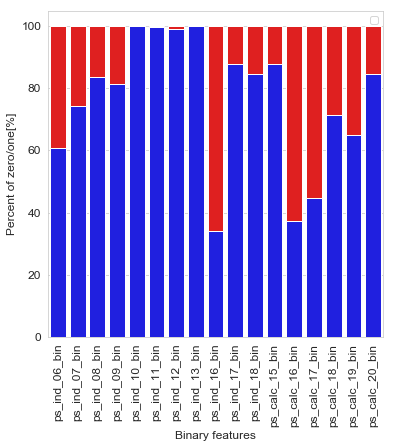

In [19]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list=[]
one_list=[]

for col in bin_col:
    zero_list.append((train[col]==0).sum()/train.shape[0]*100)
    one_list.append((train[col]==1).sum()/train.shape[0]*100)

plt.figure()
fig, ax = plt.subplots(figsize=(6,6))

# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, color="red", bottom=zero_list)
plt.ylabel('Percent of zero/one[%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.legend((p1,p2),('Zero','One'))
plt.show()
    

**ps_ind_10_bin**, **ps_ind__11_bin**, **ps_ind_12_bin** and **ps_ind_13_bin** have very small number of values `1` whilst the number of value `1` is very large for **ps_ind_16_bin** and **ps_calc_16_bin** (more than 60%)

Let's see now the distribution of binary data and the coreesponding values of **target** variable

<Figure size 432x288 with 0 Axes>

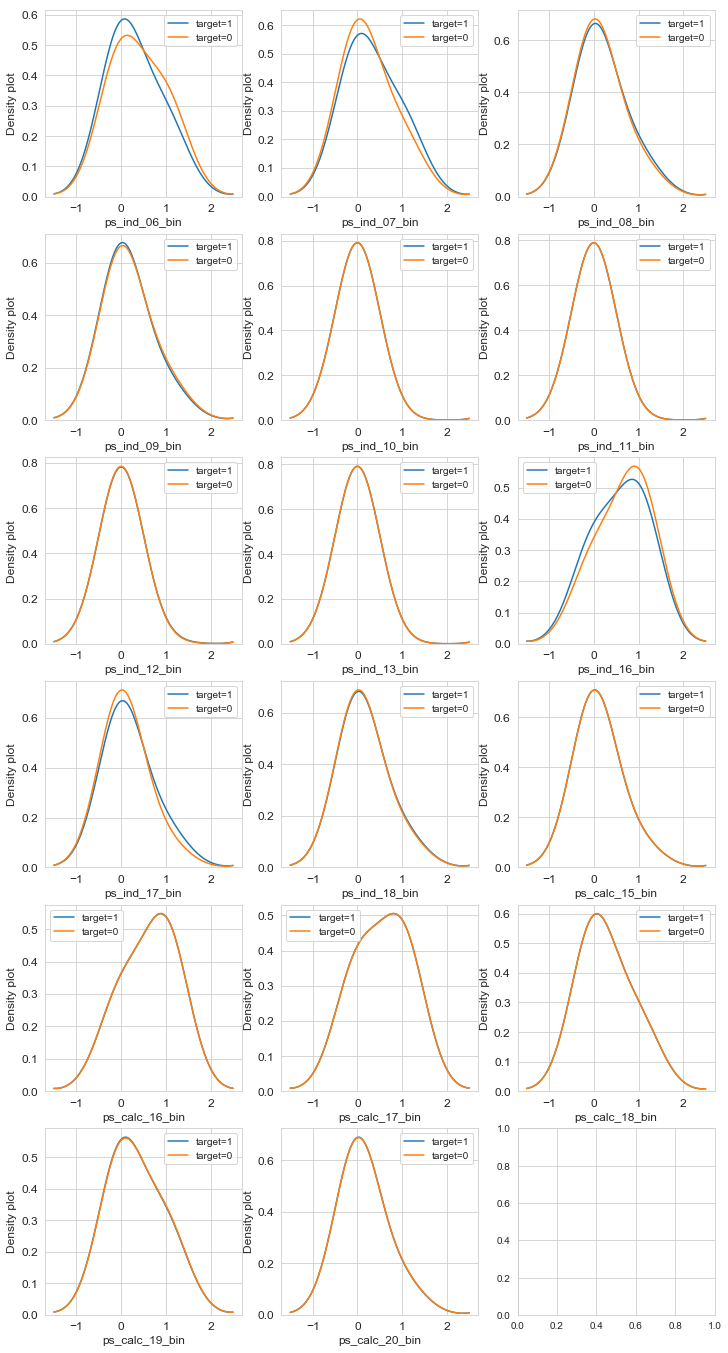

In [20]:
var = meta[(meta.level == 'binary') & (meta.keep)].index
var = [col for col in train.columns if '_bin' in col]

i=0
t1 = train.loc[train['target'] != 0]
t0 = train.loc[train['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

**ps_ind_06_bin**, **ps_ind_07_bin**, **ps_ind_16_bin**, **ps_ind_17_bin** shows high imbalance between distribution of values of `1` and `0`. **ps_ind_08_bin** shows small imbalance while the other features are well balanced, haveing similar density plots

### Categorical features

We will represent the distribution on `categorical` data in two ways 

First, we calculate the percentage of `target =1` per category value and represent these percentages using bar plot

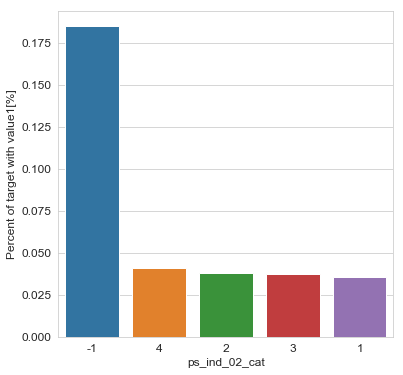

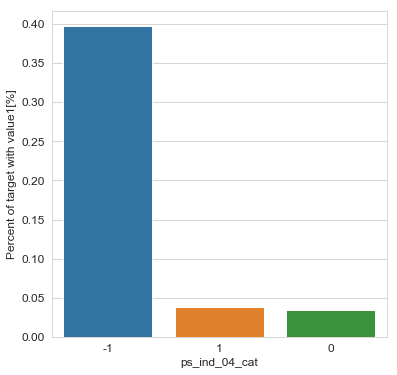

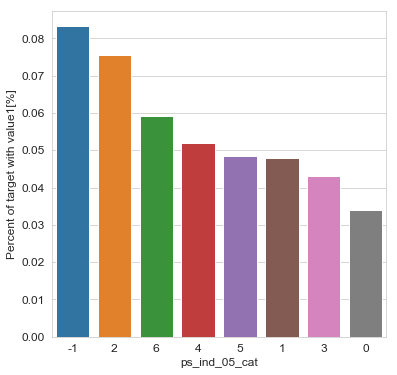

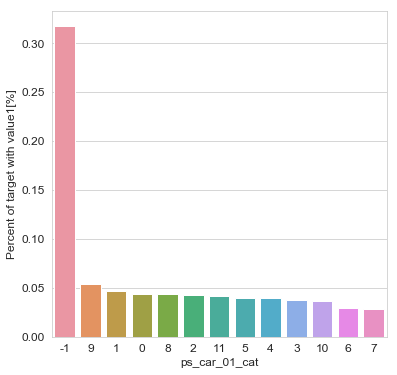

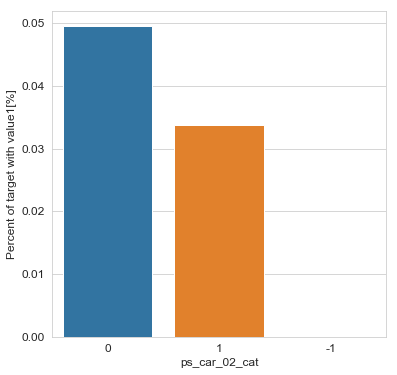

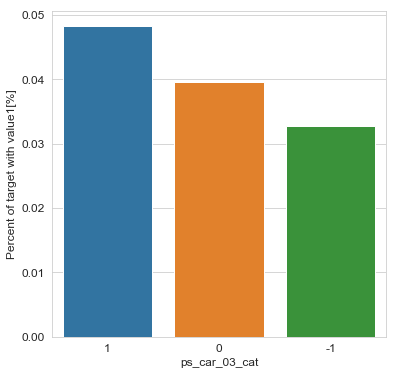

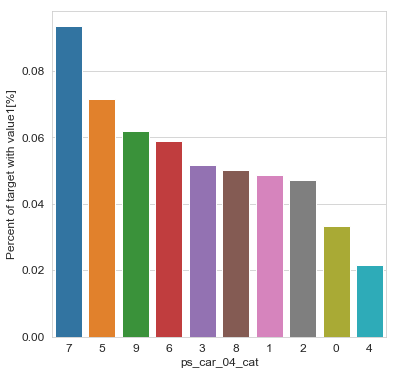

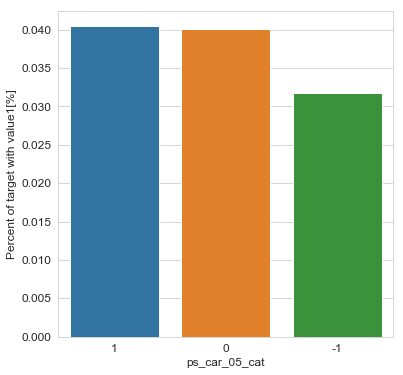

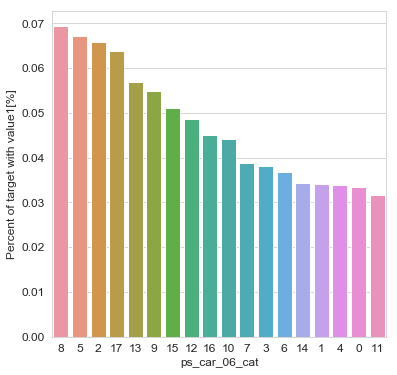

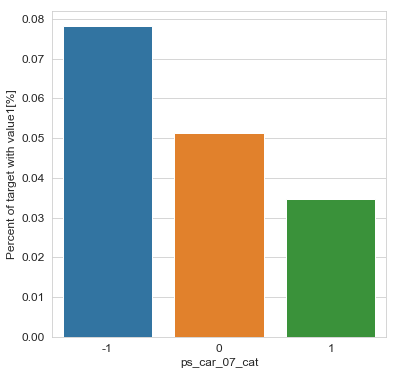

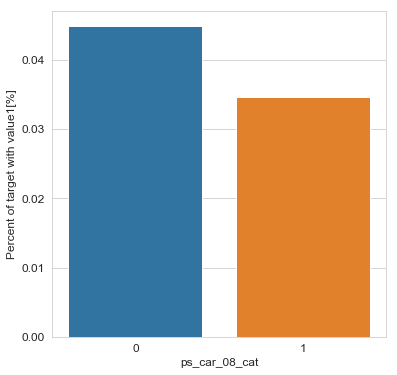

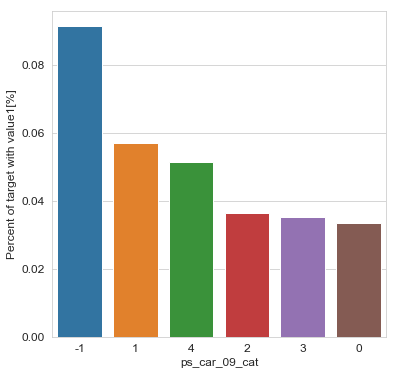

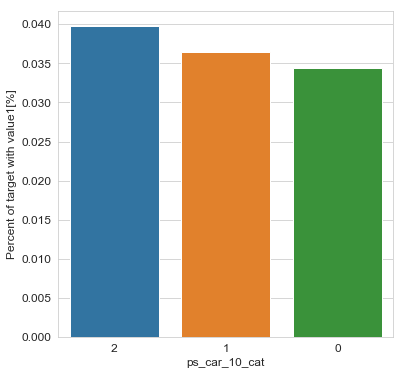

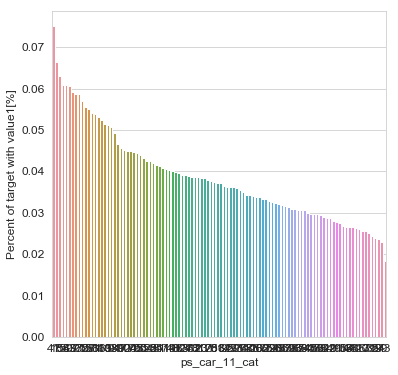

In [21]:
var = meta[(meta.level == 'categorical') & (meta.keep)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6,6))
    # Calculate the percentage of target = 1 per category value
    cat_perc = train[[feature, 'target']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar Plot
    # Order the bars descending on taret mean
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value1[%]', fontsize=12)
    plt.xlabel(feature,fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

Alternatively we represent the `categorical` features using density plot. We select values with `target =0` and `target=1` and represent both density plots on the same graphic

<Figure size 432x288 with 0 Axes>

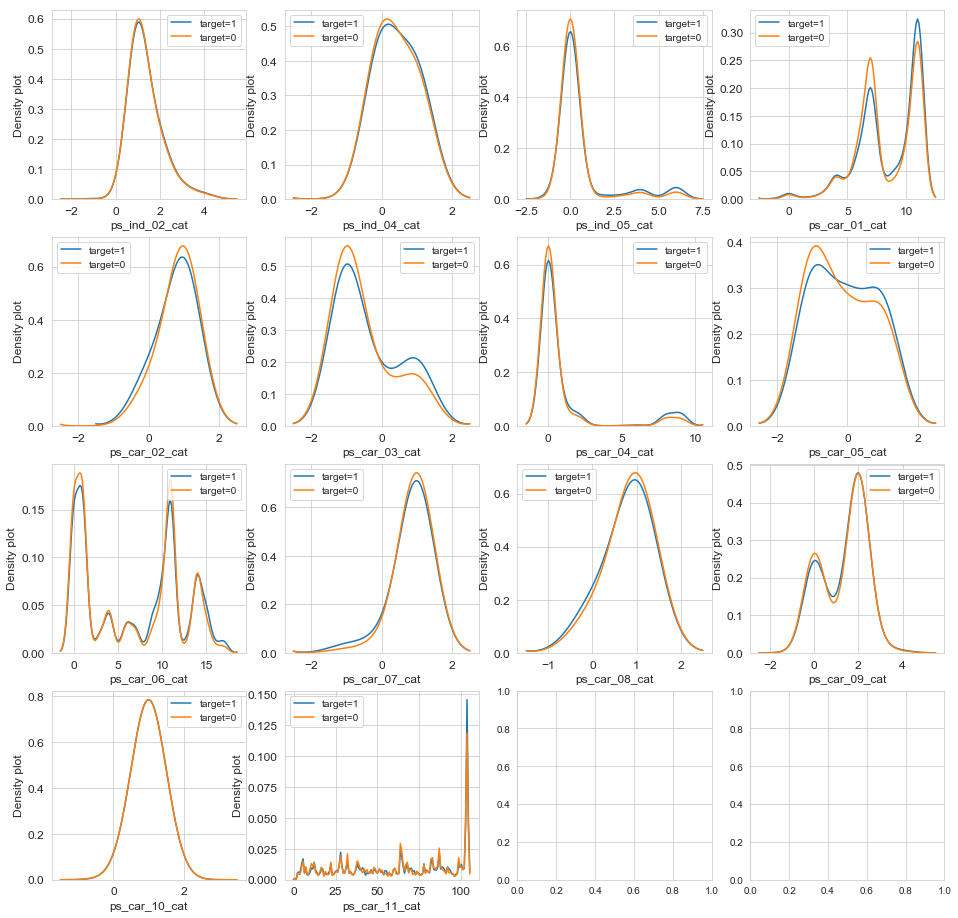

In [22]:
var = meta[(meta.level=='categorical')&(meta.keep)].index

i=0
t1 = train.loc[train['target'] != 0]
t0 = train.loc[train['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax=plt.subplots(4,4,figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4,4,i)
    sns.kdeplot(t1[feature], bw=0.5, label="target=1")
    sns.kdeplot(t0[feature], bw=0.5, label="target=0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis="both", which="major", labelsize=12)
    
plt.show()

**ps_car_03_cat**, **ps_car_05_cat** shows the most different density plot between values associated with `target=0` and `target=1`

## Data unbalance bewteen train and test data

Let's compare the distribution of the featurs in the train and test datasets.

We start with the `reg` or `registration` features

<Figure size 432x288 with 0 Axes>

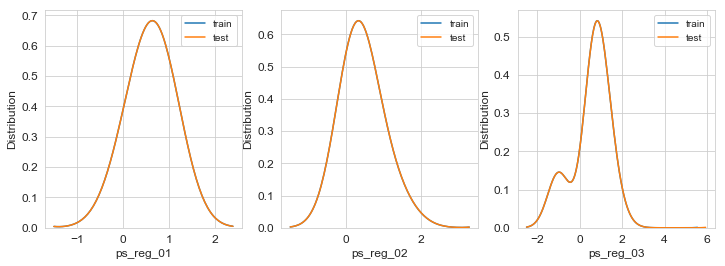

In [23]:
var=meta[(meta.category =='registration') & (meta.keep)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i=0

for feature in var:
    i += 1
    plt.subplot(1,3,i)
    sns.kdeplot(train[feature], bw=0.5, label="train")
    sns.kdeplot(test[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels=plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    
plt.show()

All `reg` features shows well balanced between train and test sets

Let's continue with `car` features

<Figure size 432x288 with 0 Axes>

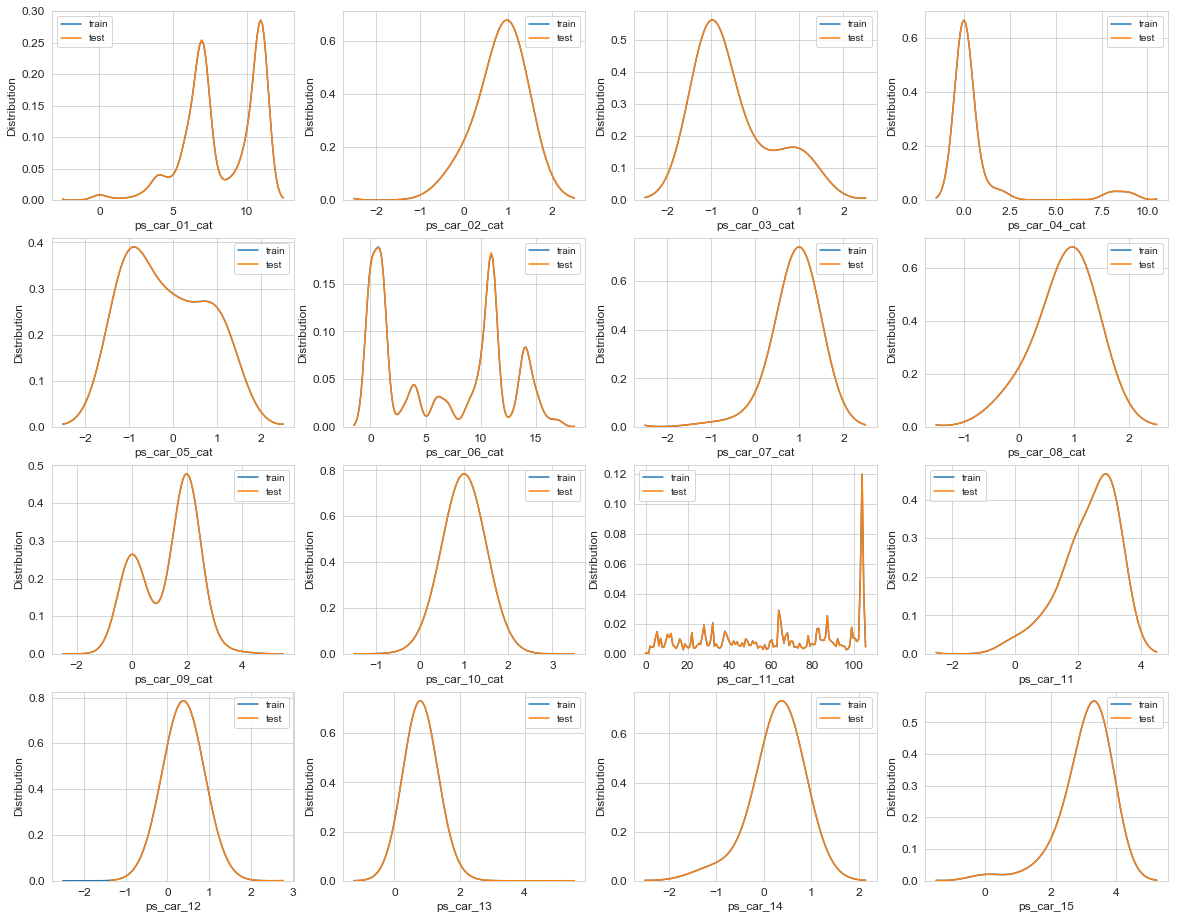

In [24]:
var = meta[(meta.category == 'car') & (meta.keep)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))
i = 0
for feature in var:
    i +=1
    plt.subplot(4,4,i)
    sns.kdeplot(train[feature], bw=0.5, label="train")
    sns.kdeplot(test[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

From the `car` features, all variables looks well balanced between `train` and `test` set.

Let's look the `ind`(`individual`) valeus

<Figure size 432x288 with 0 Axes>

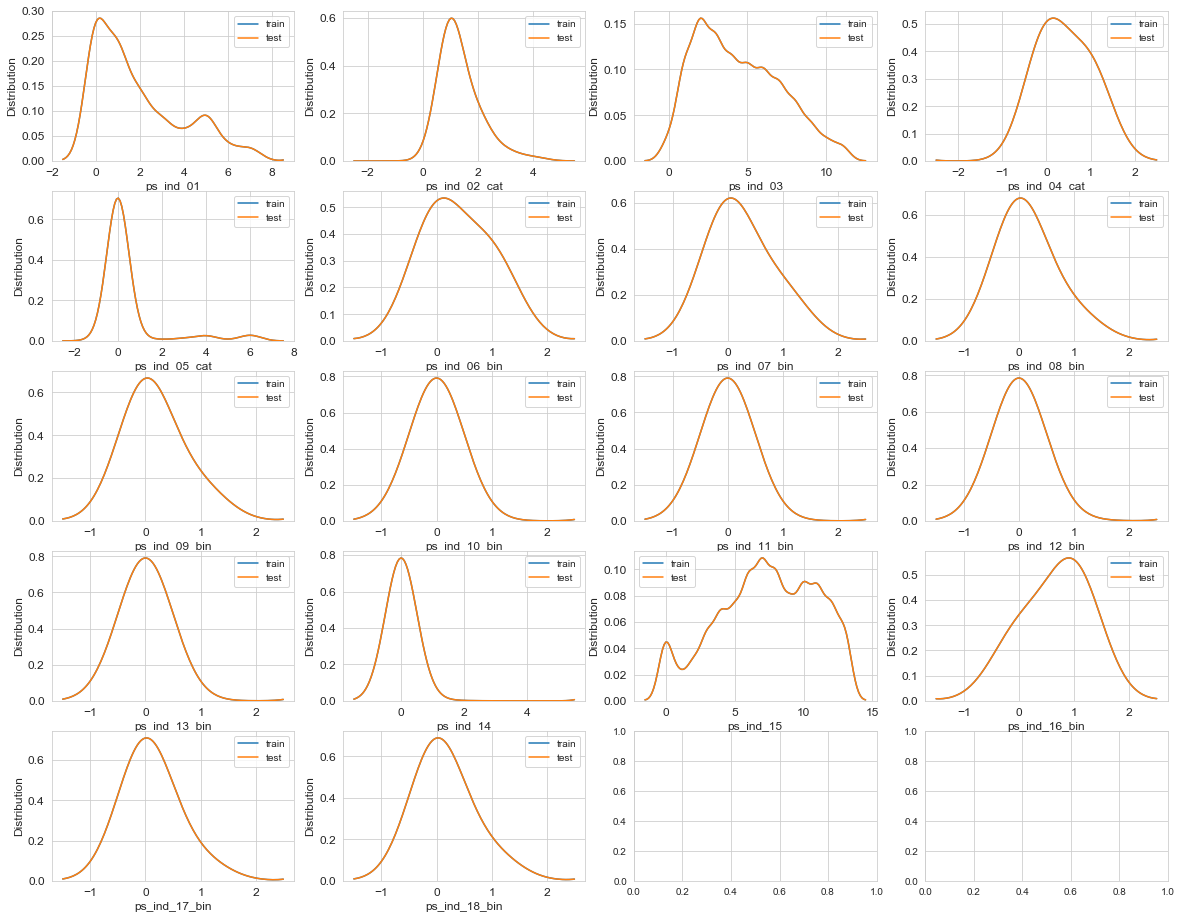

In [25]:
var = meta[(meta.category =='individual') & (meta.keep)].index

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i=0
for feature in var:
    i+=1
    plt.subplot(5,4,i)
    sns.kdeplot(train[feature], bw=0.5, label="train")
    sns.kdeplot(train[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Let's check `calc` features

<Figure size 432x288 with 0 Axes>

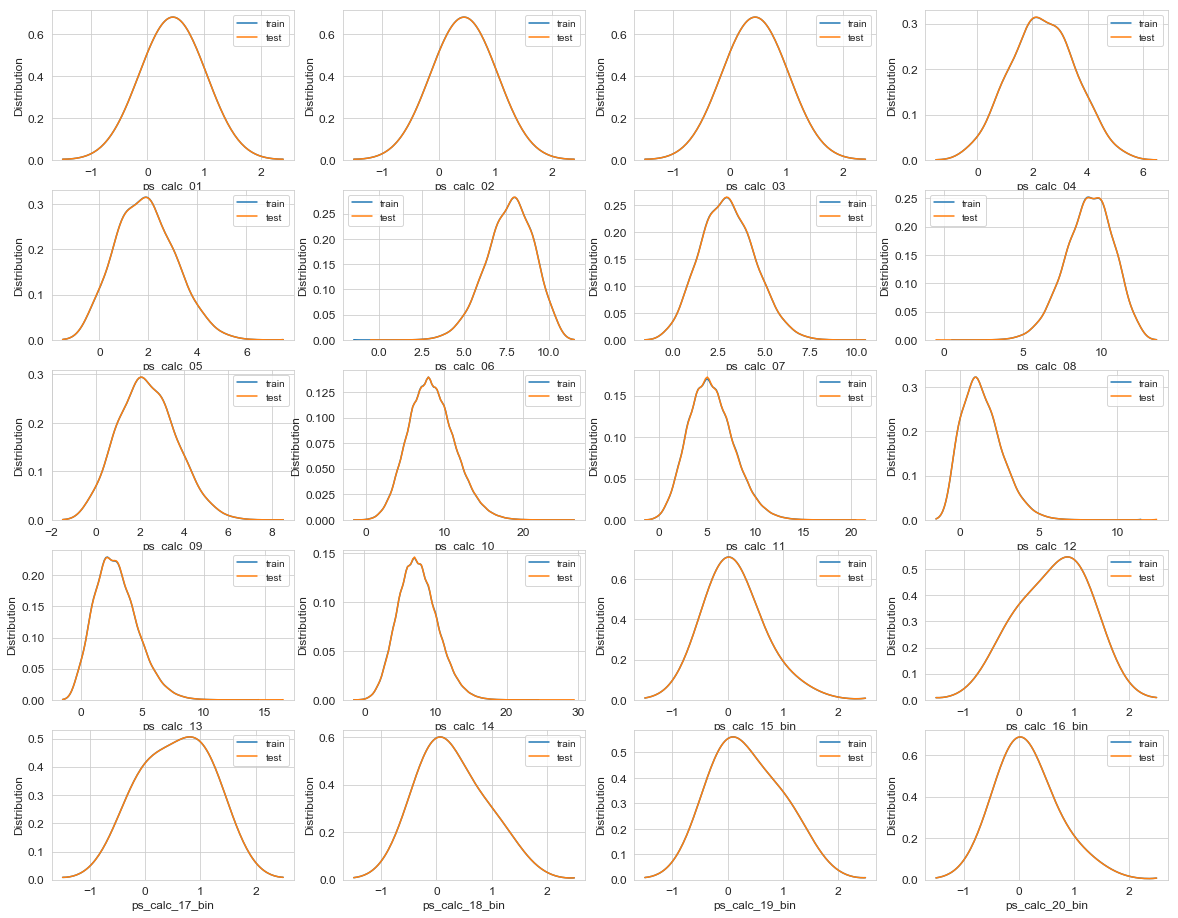

In [26]:
var = meta[(meta.category == 'calculated') & (meta.keep)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig,ax = plt.subplots(5,4,figsize=(20,16))
i=0
for feature in var:
    i += 1
    plt.subplot(5,4,i)
    sns.kdeplot(train[feature], bw=0.5, label="train")
    sns.kdeplot(test[feature], bw=0.5, label="test")
    plt.ylabel("Distribution", fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
plt.show()

All `calc` features are well balanced between `train` and `test` sets

In reference[5], it is also noticed te well balancing between `train` and `test` sets. It is also suggested that `calc` features might be all engineered and actually not relevant. This can only be assessed by careful succesive eliminating using `CV` score using one or more predictive models

## Check data quality

In [27]:
vars_with_missing=[]

for feature in train.columns:
    missing = train[train[feature] == -1][feature].count()
    if missing>0:
        vars_with_missing.append(feature)
        missings_perc = missing/train.shape[0]
        
        print('Variable {} has {} records({:.2%}) with missing values'.format(feature, missing, missings_perc))
print("")
print("In total, there are {} variables with missing values".format(len(vars_with_missing)))


Variable ps_ind_02_cat has 216 records(0.04%) with missing values
Variable ps_ind_04_cat has 83 records(0.01%) with missing values
Variable ps_ind_05_cat has 5809 records(0.98%) with missing values
Variable ps_reg_03 has 107772 records(18.11%) with missing values
Variable ps_car_01_cat has 107 records(0.02%) with missing values
Variable ps_car_02_cat has 5 records(0.00%) with missing values
Variable ps_car_03_cat has 411231 records(69.09%) with missing values
Variable ps_car_05_cat has 266551 records(44.78%) with missing values
Variable ps_car_07_cat has 11489 records(1.93%) with missing values
Variable ps_car_09_cat has 569 records(0.10%) with missing values
Variable ps_car_11 has 5 records(0.00%) with missing values
Variable ps_car_12 has 1 records(0.00%) with missing values
Variable ps_car_14 has 42620 records(7.16%) with missing values

In total, there are 13 variables with missing values


## Prepare the data for model

### Drop calc columns

We also drop the **calc** columns, as recommended in [5]. These seems to be all engineered. According to Dmitry Altukhov, he was able to improve his CV score while succesivelly removing all of them.


In [28]:
drop_columns = train.columns[train.columns.str.startswith('ps_calc_')]

train = train.drop(drop_columns, axis=1)
test = test.drop(drop_columns, axis=1)


### Drop variables with too many missing values

We select from the variables with missing values, **ps_car_03_cat** and **ps_car_05_cat** to drop

In [29]:
# Dropping the variables with too many missing values

drop_vars = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(drop_vars, inplace=True, axis=1)
test.drop(drop_vars, inplace=True, axis=1)
meta.loc[(drop_vars),'keep'] = False # Updating meta


In [30]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

def add_noise(series, noise_level):
    return series*(1+noise_level*np.random.randn(len(series)))

def target_encoded(trn_series=None,
                  tst_series=None,
                   target = None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Varreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categorical
    trn_series: training categorical feature as a pd.Series
    tst_series: test categorical feature as a pd.Series
    target: target data as a pd.Series
    min_smaples_leaf(int): minimum samples to take category average into account
    smoothing(int): smoothing effect to balance categorical average vs prior
    """
    
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean
    average = temp.groupby(by=trn_series.name)[target.name].agg(["mean","count"])
    
    # Compute smoothing
    smoothing = 1 / (1+np.exp(-(average["count"] - min_samples_leaf / smoothing)))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_abg is taken into account
    average[target.name] = prior * (1-smoothing) + average['mean']*smoothing
    average.drop(['mean','count'], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name),
                            average.reset_index().rename(columns={'index':target.name, target.name: 'average'}),
                            on = trn_series.name,
                            how='left')['average'].rename(trn_series.name + '_mean')
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(tst_series.to_frame(tst_series.name),
                            average.reset_index().rename(columns={'index': target.name, target.name:'average'}),
                            on=tst_series.name,
                            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    #pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)


### Replace ps_car_11_cat with encoded value

Using the **target_encode** function, we replace the **ps_car_11_cat** with an encoded value in both **train** and **test** data

In [31]:
train_encoded, test_encoded = target_encoded(train['ps_car_11_cat'],
                                            test['ps_car_11_cat'],
                                            target = train.target,
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)

train['ps_car_11_cat_encoded'] = train_encoded
train.drop('ps_car_11_cat', axis = 1, inplace = True)
meta.loc['ps_car_11_cat', 'keep'] = False # Updating the meta data

test['ps_car_11_cat_encoded'] = test_encoded
test.drop('ps_car_11_cat', axis = 1, inplace=True)


### Balance target variabel

The target variable is highly unbalanced. This can be improved by either undersampling values with **target=0** or oversampling values with **target=1**. Because here is a rather large training wet. We opt for the **undersampling**

In [32]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target==0].index
idx_1 = train[train.target==1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target = 0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print("Rate to undersample records with target=0: {}".format(undersampling_rate))
print('Number of records with target = 0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target = 0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx)+ list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)



Rate to undersample records with target=0: 0.34043569687437886
Number of records with target = 0 after undersampling: 195246


### Replace -1 values with NaN

most of the classifiers we would use have preety good strategies to manage missing (or NaN) values

In [33]:
train = train.replace(-1, np.nan)
test = test.replace(-1, np.nan)


### Dummy cat values

We will create dummy variables for the **Categorical (cat)** features

In [34]:
categorical_features = [c for c in train.columns if c.endswith('cat')]

for column in categorical_features:
    temp = pd.get_dummies(pd.Series(train[column]))
    train = pd.concat([train, temp], axis=1)
    train = train.drop([column], axis=1)
    
for column in categorical_features:
    temp = pd.get_dummies(pd.Series(test[column]))
    test = pd.concat([test, temp], axis=1)
    test = test.drop([column], axis=1)
    

Let's inspect the train and test data

In [35]:
print("Train data (rows, cols):", train.values.shape, "\nTest data (rows, cols)", test.values.shape)

Train data (rows, cols): (216940, 93) 
Test data (rows, cols) (892816, 92)


## Prepare the model

### Ensanble class for cross validation and ensamble

Prepare and **Ensamble** class to split the data in Kfolds, train the models and ensamble the results.

The class has an **init** method (called when an Ensamble object is created that accepts 4 parameters):

1. **self** - The object to be initialized
2. **n_splits** - The number of cross-validation splits to be used
3. **stacker** - the model used for staking the prediction results from the trained bas models
4. **base_models** - the list of base models used in training

A second method, **fit_predict** has four functions:
    
1. split the training data in **n_splits** folds
2. run the **base** models for each fold
3. perform prediction using each model
4. ensamble the results using the **stacker**


In [36]:
class Ensamble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
        
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.arrya(T)
        
        folds = list(StartifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X,y))
        
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                
                print("Base model%d: fit %s model | fold %d" % (i+1, str(clf).split("(")[0], j+1))
                clf.fit(X_train,y_train)
                crss_score = cross_val_score(clf, X_train, y_train, cv=3, scoring = 'roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]
                
                S_train[test_idx, i] = y_pred
                S_test_i[:,j] = clf.predict_proba(T)[:,1]
            S_test[:,i] = S_test_i.mean(axis=1)
            
            results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
            
            # Calculate gini factor as 2* AUC -1
            print("Stacker score [ gini]: %.5f" % (2*results.mean() -1 ))
            
            self.stacker.fit(S_train,y)
            res = self.stacker.predict_proba(S_test)[:,1]
            return res

### Parameter for the base models

For the base models, we prepare three different LightGBM models and one XGB model.

Each model is used to train the data (using as well cross-validation with 3 folds)


In [37]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb_2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb_3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_Rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

### Initialize the models with the parameters 

We init the 3 base models and the stacking model. For the base models we are using the predefined parameters initialized above

In [38]:
# Base models

lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

### Initialize the ensambling object

using Ensamble init we init the stacking object

In [39]:
stack = Ensamble (n_splits=3, 
                 stacker = log_model,
                 base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))


## Run the predictive models

Calling the **fit_predict** method of **stack** object, we run the training of the base models, predict the **target** with each model, ensamble the results using the **stacker** model and output the stacked result 

In [40]:
y_prediction = stack.fit_predict(train,target_train, test)

NameError: name 'target_train' is not defined

## Submit

In [ ]:
submission =pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)